In [2]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from GRU_pipeline import DataHolder, paths, MultiModalDicDataset, GRUModel, pad_collate
from models import GRUMultiModal, GRUBiModal

DH = DataHolder(**paths, none_as_class=True)

train_test_1 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 1, none_count = 2000, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 2, none_count = 2000, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x) ** 3 for x in class_weights])

In [22]:
train_dataset_1 = MultiModalDicDataset(**train_test_1['data'])
test_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["test_dic_openface"], train_dic_opensmile = train_test_1["data"]["test_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["valid_dic_openface"], train_dic_opensmile = train_test_1["data"]["valid_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = MultiModalDicDataset(**train_test_2['data'])
test_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["test_dic_openface"], train_dic_opensmile = train_test_2["data"]["test_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["valid_dic_openface"], train_dic_opensmile = train_test_2["data"]["valid_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [33]:
train_dictionaries = ["train_dic_opensmile", "train_dic_openface"]
val_dictionaries = ["valid_dic_opensmile", "valid_dic_openface"]
test_dictionaries = ["test_dic_opensmile", "test_dic_openface"]

sets = [train_test_1, train_test_2]

for train in train_dictionaries:
    train_1 = set(train_test_1["data"][train].keys())
    train_2 = set(train_test_2["data"][train].keys())
    for test in test_dictionaries:
        test_1 = train_test_1["data"][test]
        test_2 = train_test_2["data"][test]
        print(train_1.intersection(test_1))
        print(train_1.intersection(test_2))
        print(train_2.intersection(test_1))
        print(train_2.intersection(test_2))
    for val in val_dictionaries:
        val_1 = train_test_1["data"][val]
        val_2 = train_test_2["data"][val]
        print(train_1.intersection(val_1))
        print(train_1.intersection(val_2))
        print(train_2.intersection(val_1))
        print(train_2.intersection(val_2))


# print(set(list(train_test_1["data"]["valid_dic_opensmile"].keys())).symmetric_difference(set(list(train_test_1["data"]["valid_dic_openface"].keys()))))

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


In [5]:
def eval_on_val():
    model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = model(embeds, features_os, features_of)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = model(embeds, features_os, features_of)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return (tot_loss / (len(val_loader_1) + len(val_loader_2)))

def train_one_epoch(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss):

    model.train(True)

    epoch_loss = 0.0

    for i, batch in enumerate(dataloader_1):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = epoch_loss / (len(dataloader_1) + len(dataloader_2))
    hist_train_loss = hist_train_loss + [epoch_loss]
    model.train(False)
    val_loss = eval_on_val()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 30 == 0:
        stagnation += 1
        print("EPOCH {}:".format(epoch + 1))
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {1000 * epoch_loss}, Val loss = {1000 * val_loss}\n================")
        if val_loss < best_vloss:
            best_vloss = val_loss
            torch.save(model.state_dict(), "models/MultiModalBert")
            stagnation = 0
    return hist_train_loss, hist_val_loss, stagnation, best_vloss

In [6]:
PARAMS = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":3, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":3, 
            "output_dim":6, 
            "dropout_prob":.1}

model = GRUMultiModal(**PARAMS)
criterion = torch.nn.BCELoss(class_weights)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
stagnation= 0
best_vloss = 1000
for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    hist_train_loss, hist_val_loss, stagnation, best_vloss = train_one_epoch(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss
    )

    if stagnation > 2:
        break
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:05<46:17,  5.57s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 2.475186824798584, Val loss = 2.355764150619507


  6%|▌         | 30/500 [02:36<39:55,  5.10s/it]

EPOCH 31:


  6%|▌         | 31/500 [02:42<41:06,  5.26s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.4180663526058197, Val loss = 0.4516772925853729


 12%|█▏        | 60/500 [05:10<37:26,  5.11s/it]

EPOCH 61:


 12%|█▏        | 61/500 [05:15<37:03,  5.07s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.2742640972137451, Val loss = 0.3131050169467926


 18%|█▊        | 90/500 [07:56<38:55,  5.70s/it]

EPOCH 91:


 18%|█▊        | 91/500 [08:01<37:35,  5.52s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.16848738491535187, Val loss = 0.2220083773136139


 24%|██▍       | 120/500 [10:47<37:27,  5.92s/it]

EPOCH 121:


 24%|██▍       | 121/500 [10:52<35:31,  5.62s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.12452547997236252, Val loss = 0.18089602887630463


 30%|███       | 150/500 [14:34<41:23,  7.09s/it]  

EPOCH 151:


 30%|███       | 151/500 [14:40<39:15,  6.75s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1056242510676384, Val loss = 0.1658182293176651


 36%|███▌      | 180/500 [18:12<38:50,  7.28s/it]

EPOCH 181:


 36%|███▌      | 181/500 [18:17<35:01,  6.59s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.08357290178537369, Val loss = 0.1582994908094406


 42%|████▏     | 210/500 [21:08<27:28,  5.68s/it]

EPOCH 211:


 42%|████▏     | 211/500 [21:13<26:20,  5.47s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.06720192730426788, Val loss = 0.16422264277935028


 48%|████▊     | 240/500 [25:22<46:52, 10.82s/it]  

EPOCH 241:


 48%|████▊     | 241/500 [25:27<40:11,  9.31s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.05971710383892059, Val loss = 0.17431628704071045


 54%|█████▍    | 270/500 [28:06<21:01,  5.49s/it]

EPOCH 271:


 54%|█████▍    | 270/500 [28:11<24:00,  6.26s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.04212835803627968, Val loss = 0.1696416139602661


# Evaluation of the model

2it [00:00, 17.48it/s]
2it [00:00, 18.32it/s]
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

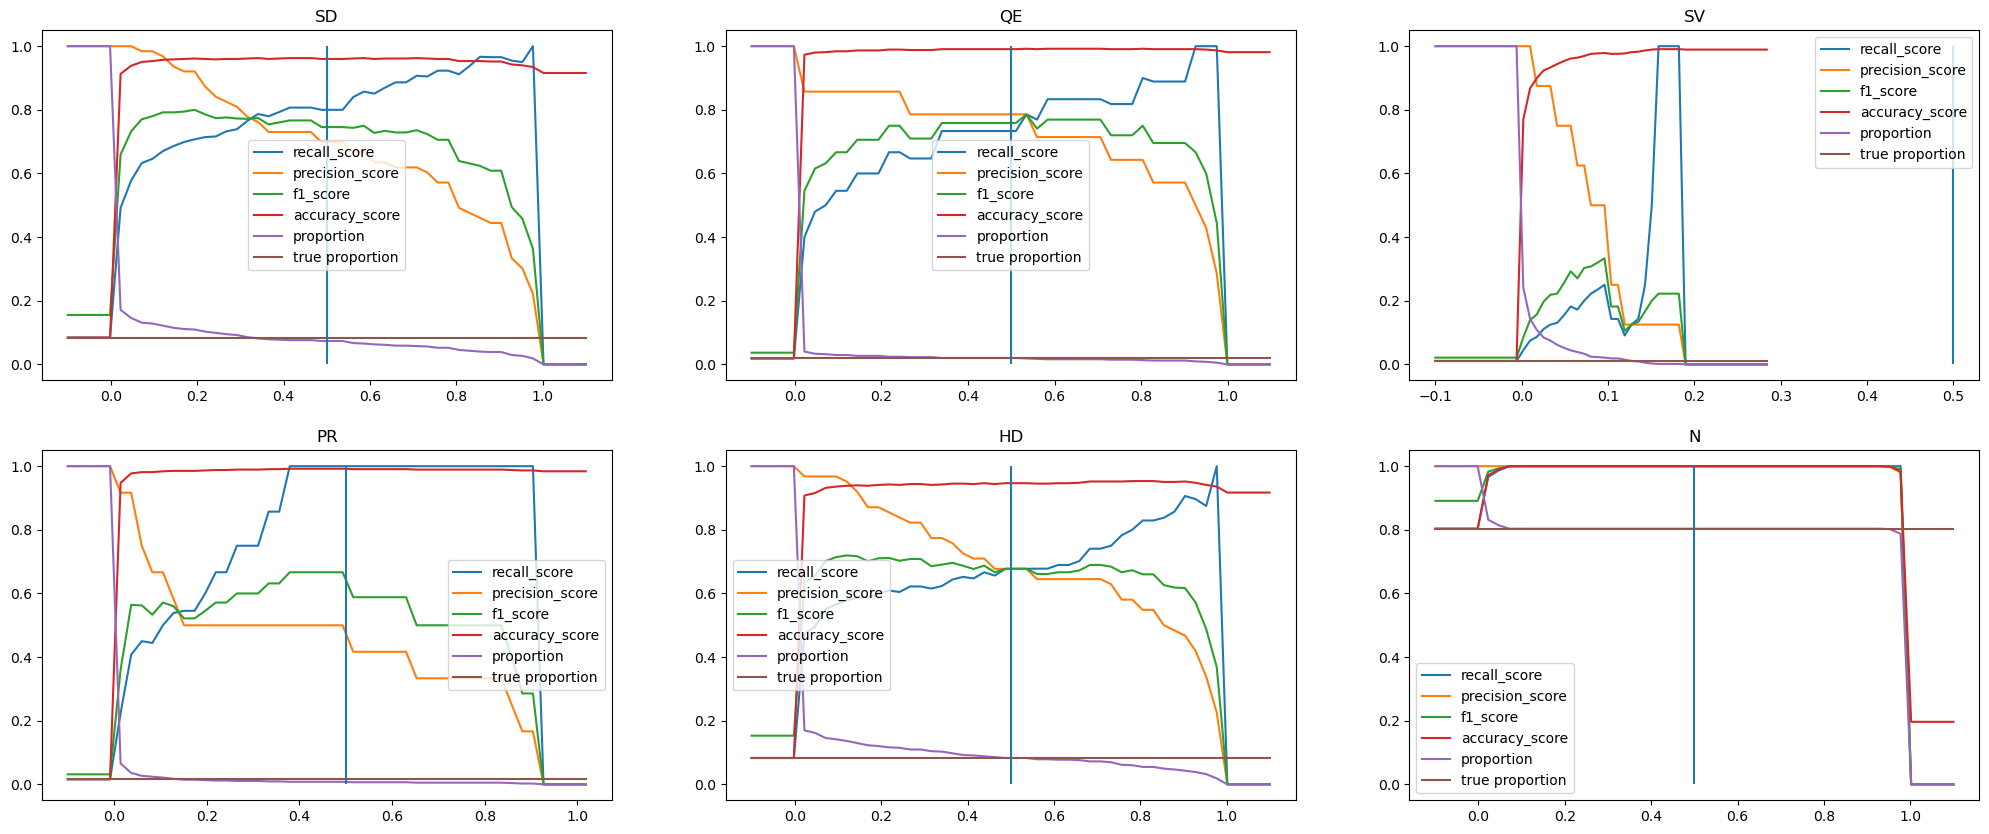

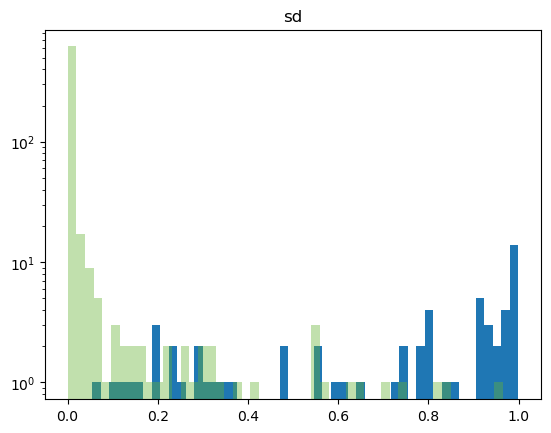

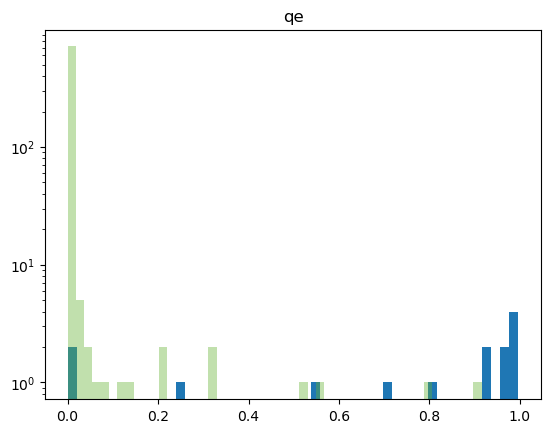

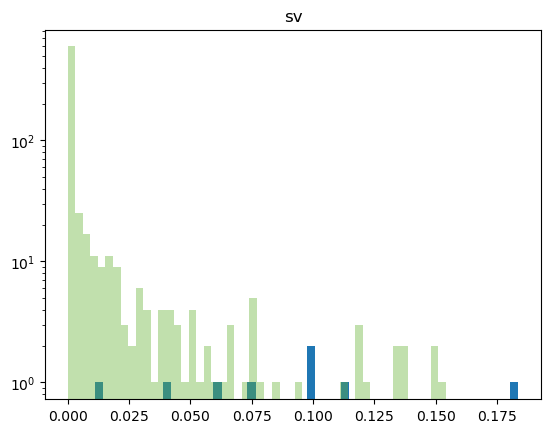

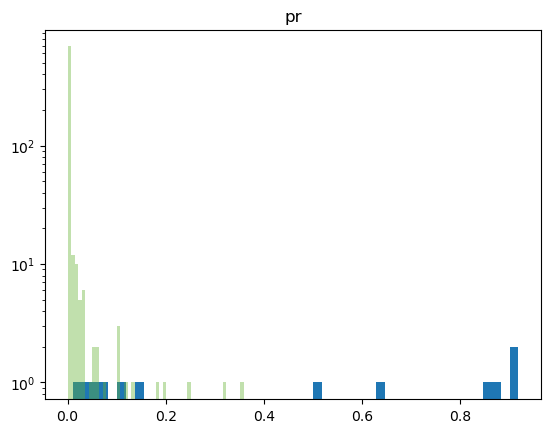

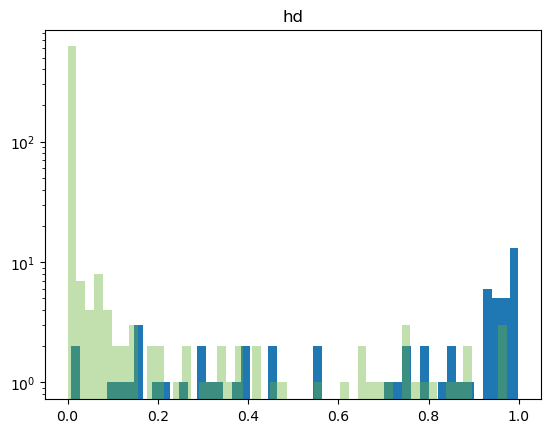

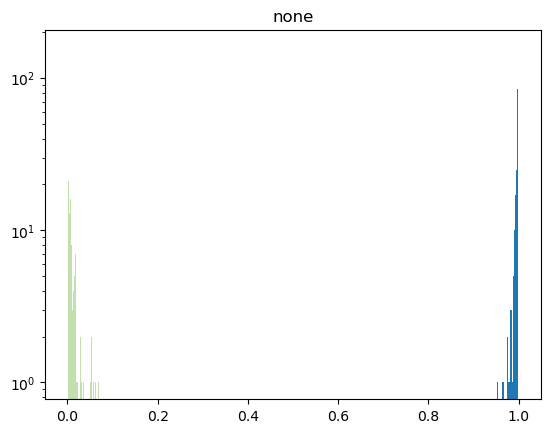

In [7]:
model = GRUMultiModal(**PARAMS)
model.load_state_dict(torch.load("models/MultiModalBert"))

fin_targets = []
fin_outputs = []

with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true = np.asarray(fin_targets)
pred_n = np.asarray(fin_outputs)

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
df_pred = pd.DataFrame(pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df_true = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1)
plt.savefig('BEAUTY_multimodal.jpg')
plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("qe")
plt.yscale("log")
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sv")
plt.yscale("log")
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("pr")
plt.yscale("log")
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("hd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("none")
plt.yscale("log")
plt.show()

# COMPARISON WITH TEXT ONLY

In [8]:
from transformers import BertModel, DistilBertTokenizer, DistilBertModel

class BertClassif(torch.nn.Module):
    """
    This model is a bi-modal classifier using a bilinear fusion layer for the two modalities.
    Text is embedded through pre-trained BERT, Action Units are embedded through two dense layers.
    """

    def __init__(self):
        super(BertClassif, self).__init__()

        # Define the Bert pipeline
        self.embeds_fc1 = torch.nn.Linear(768, 768)
        self.embeds_fc2 = torch.nn.Linear(768, 768 // 2)
        self.classifier = torch.nn.Linear(768 // 2, 6) # 6

        self.dropout = torch.nn.Dropout(0.25)
        self.class_num = 6
        self.ReLU = torch.nn.LeakyReLU(.1)
        self.sigmoid = torch.nn.Sigmoid()
        # Define the classifier

    def forward(self, embeddings):

        embeds_x = self.embeds_fc1(embeddings)
        embeds_x = self.ReLU(embeds_x)

        embeds_x = self.embeds_fc2(embeds_x)
        embeds_out = self.ReLU(embeds_x)

        out = self.classifier(embeds_out)
        out = self.sigmoid(out)
        return out

In [9]:
def eval_on_val_text():
    txt_model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        embeds, targets = batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = txt_model(embeds)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        embeds, targets = batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = txt_model(embeds)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return (tot_loss / (len(val_loader_1) + len(val_loader_2)))

def train_one_epoch_text(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss):

    txt_model.train(True)

    epoch_loss = 0.0

    for i, batch in enumerate(dataloader_1):
        embeds, targets = batch['embeds'], batch['targets']
        pred = txt_model(embeds)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        embeds, targets = batch['embeds'], batch['targets']
        pred = txt_model(embeds)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = epoch_loss / (len(dataloader_1) + len(dataloader_2))
    hist_train_loss = hist_train_loss + [epoch_loss]
    txt_model.train(False)
    val_loss = eval_on_val_text()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 30 == 0:
        stagnation += 1
        print("EPOCH {}:".format(epoch + 1))
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {1000 * epoch_loss:.4f}, Val loss = {1000 * val_loss:.4f}\n================")
        if val_loss < best_vloss:
            best_vloss = val_loss
            torch.save(txt_model.state_dict(), "models/BertClassif")
            stagnation = 0
    return hist_train_loss, hist_val_loss, stagnation, best_vloss

In [10]:
txt_model = BertClassif()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = txt_model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
stagnation= 0
best_vloss = 1000

for epoch in tqdm(range(EPOCHS), total = EPOCHS):
    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
    if epoch % 20 == 0:
        print("EPOCH {}:".format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    txt_model.train(True)
    hist_train_loss, hist_val_loss, stagnation, best_vloss = train_one_epoch_text(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss
    )
    

    if stagnation > 2:
        break
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:12<1:41:13, 12.17s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 3.3182, Val loss = 3.1944


  4%|▍         | 20/500 [00:18<02:27,  3.25it/s] 

EPOCH 21:


  6%|▌         | 31/500 [00:21<02:17,  3.40it/s]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7577, Val loss = 0.8133


  8%|▊         | 40/500 [00:25<03:48,  2.01it/s]

EPOCH 41:


 12%|█▏        | 60/500 [00:31<02:00,  3.64it/s]

EPOCH 61:


 12%|█▏        | 61/500 [00:32<02:08,  3.42it/s]

EPOCH 61:
Training epoch 60 :
Train loss = 0.3456, Val loss = 0.4019


 16%|█▌        | 80/500 [00:38<01:53,  3.71it/s]

EPOCH 81:


 18%|█▊        | 91/500 [00:41<01:57,  3.48it/s]

EPOCH 91:
Training epoch 90 :
Train loss = 0.2174, Val loss = 0.2563


 20%|██        | 100/500 [00:45<03:30,  1.90it/s]

EPOCH 101:


 24%|██▍       | 120/500 [00:53<01:53,  3.34it/s]

EPOCH 121:


 24%|██▍       | 121/500 [00:53<01:51,  3.39it/s]

EPOCH 121:
Training epoch 120 :
Train loss = 0.1719, Val loss = 0.2175


 28%|██▊       | 140/500 [00:59<01:36,  3.72it/s]

EPOCH 141:


 30%|███       | 151/500 [01:02<01:42,  3.40it/s]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1459, Val loss = 0.2041


 32%|███▏      | 160/500 [01:04<01:29,  3.79it/s]

EPOCH 161:


 36%|███▌      | 180/500 [01:10<01:43,  3.10it/s]

EPOCH 181:


 36%|███▌      | 181/500 [01:10<01:42,  3.10it/s]

EPOCH 181:
Training epoch 180 :
Train loss = 0.1235, Val loss = 0.1910


 40%|████      | 200/500 [01:16<01:57,  2.55it/s]

EPOCH 201:


 42%|████▏     | 211/500 [01:20<01:35,  3.03it/s]

EPOCH 211:
Training epoch 210 :
Train loss = 0.1166, Val loss = 0.1816


 44%|████▍     | 220/500 [01:24<02:09,  2.16it/s]

EPOCH 221:


 48%|████▊     | 240/500 [01:32<01:47,  2.43it/s]

EPOCH 241:


 48%|████▊     | 241/500 [01:32<01:41,  2.54it/s]

EPOCH 241:
Training epoch 240 :
Train loss = 0.1004, Val loss = 0.1947


 52%|█████▏    | 260/500 [01:40<01:58,  2.03it/s]

EPOCH 261:


 54%|█████▍    | 271/500 [01:48<03:22,  1.13it/s]

EPOCH 271:
Training epoch 270 :
Train loss = 0.0853, Val loss = 0.2021


 56%|█████▌    | 280/500 [01:51<01:05,  3.34it/s]

EPOCH 281:


 60%|██████    | 300/500 [01:57<00:54,  3.64it/s]

EPOCH 301:


 60%|██████    | 300/500 [01:57<01:18,  2.55it/s]

EPOCH 301:
Training epoch 300 :
Train loss = 0.0712, Val loss = 0.2040


2it [00:00, 141.71it/s]
2it [00:00, 135.83it/s]
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

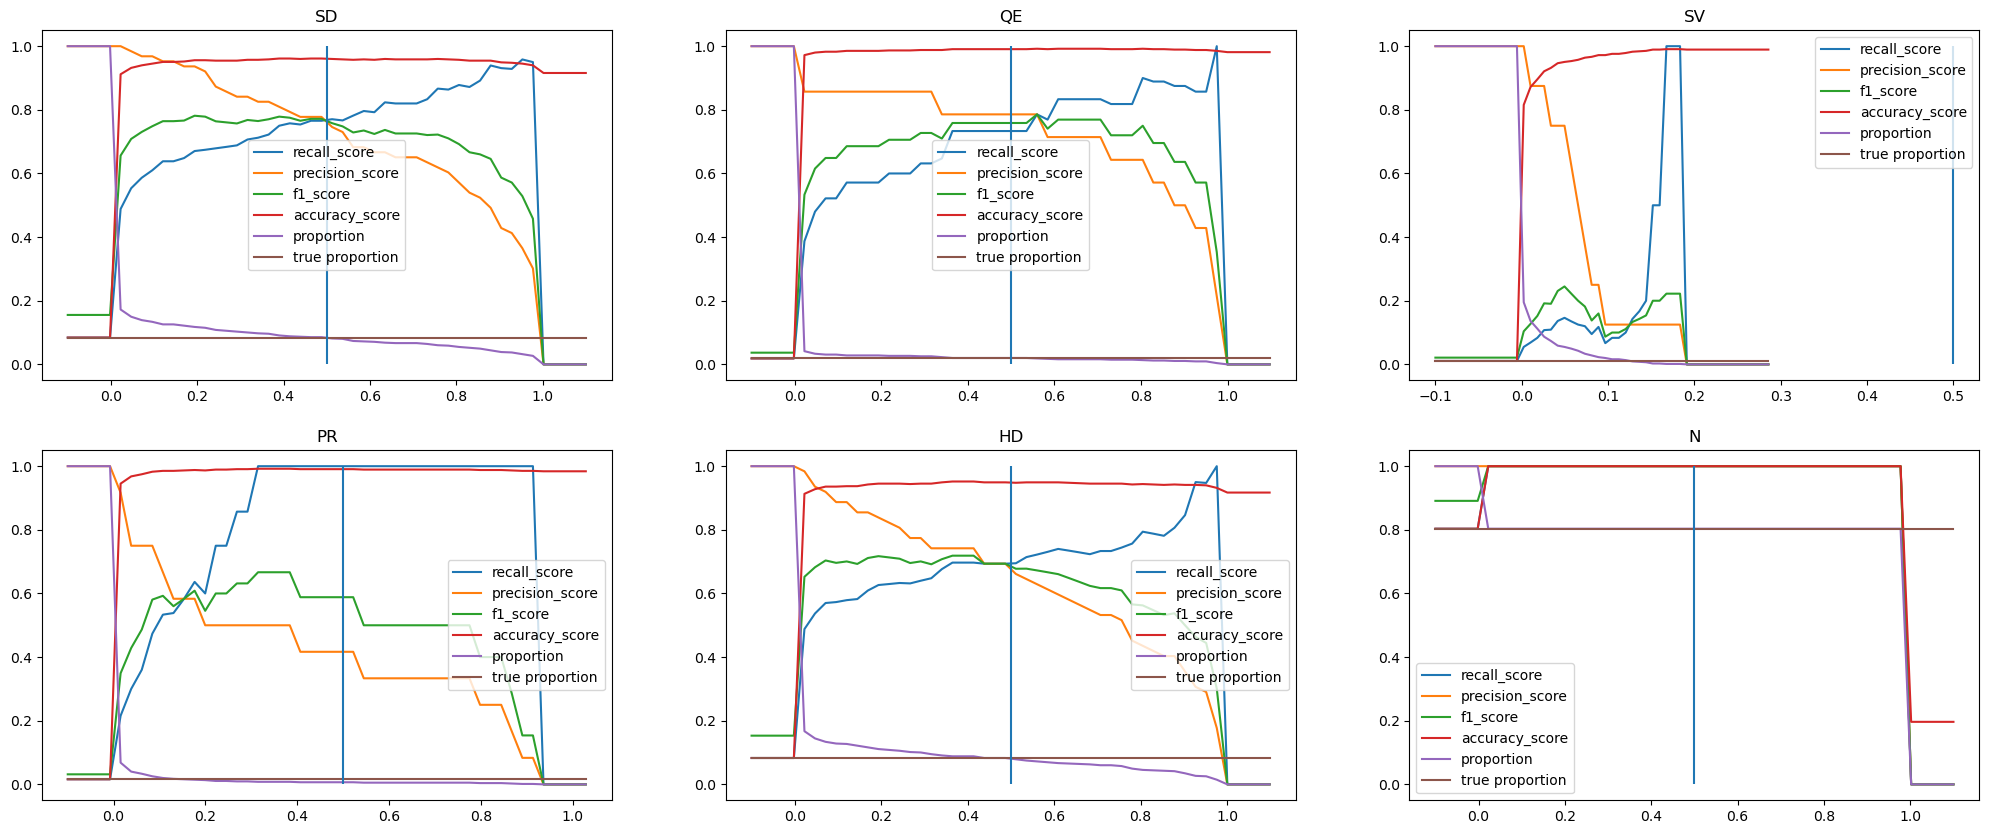

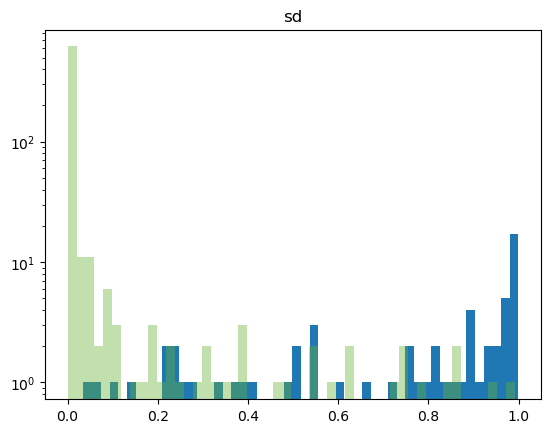

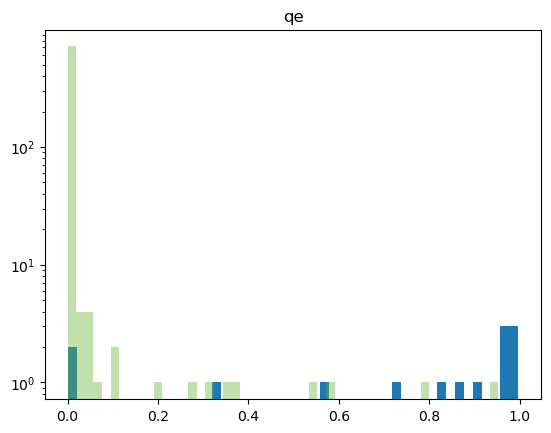

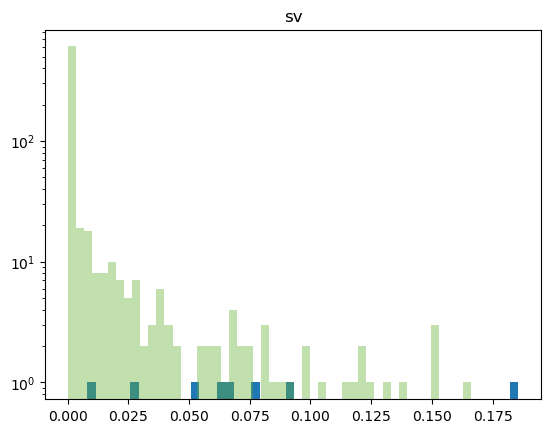

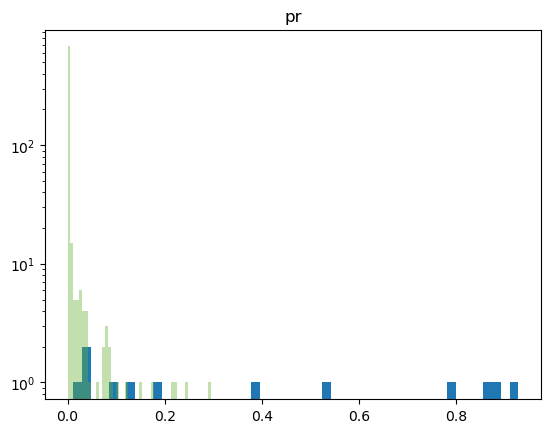

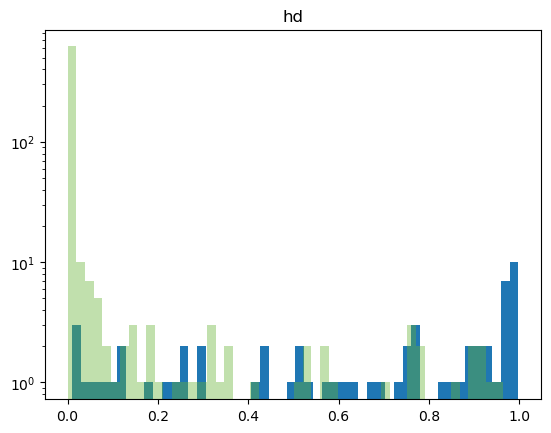

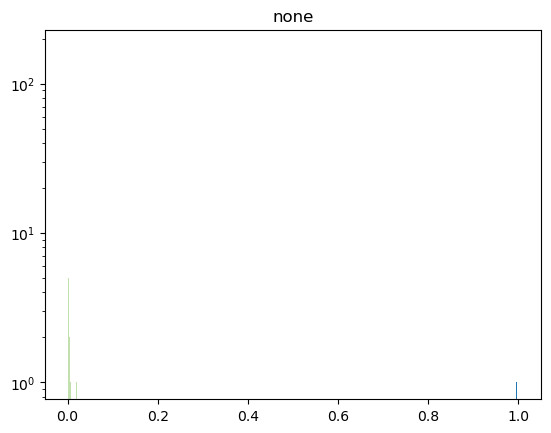

In [11]:
model_txt = BertClassif()
model_txt.load_state_dict(torch.load("models/BertClassif"))

fin_targets_txt = []
fin_outputs_txt = []


with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true_txt = np.asarray(fin_targets_txt)
pred_n_txt = np.asarray(fin_outputs_txt)

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out_txt = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out_txt = pd.DataFrame(out_txt, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out_txt

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true_txt[:,i], pred_n_txt[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1)
plt.savefig('BEAUTY_text.jpg')
plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("qe")
plt.yscale("log")
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sv")
plt.yscale("log")
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("pr")
plt.yscale("log")
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("hd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("none")
plt.yscale("log")
plt.show()

# COMPARISON BETWEEN THE TWO MODELS

2it [00:00, 50.83it/s]
2it [00:00, 30.37it/s]
2it [00:00,  3.31it/s]
2it [00:00,  3.18it/s]
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beha

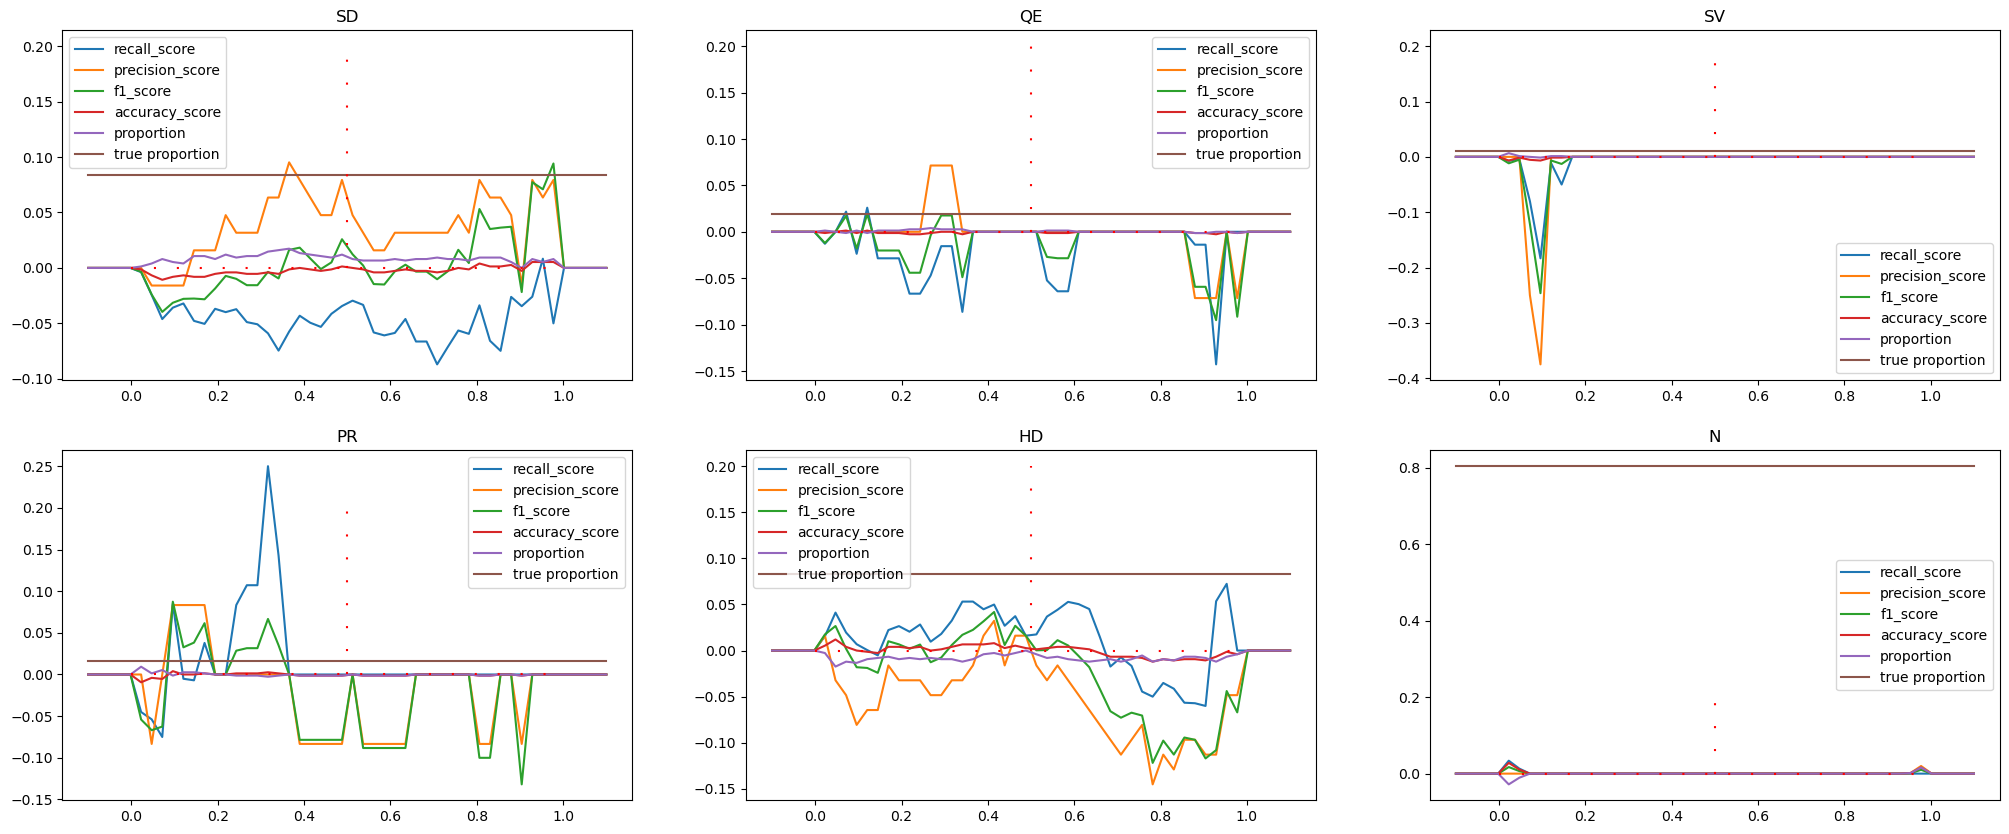

In [14]:
model_txt = BertClassif()
model_txt.load_state_dict(torch.load("models/BertClassif"))

fin_targets_txt = []
fin_outputs_txt = []


def explore_tresh(true_model_1, pred_model_1, true_model_2, pred_model_2):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        np.subtract(precision_score(true_model_1, np.where(pred_model_1>t,1,0)), precision_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(recall_score(true_model_1, np.where(pred_model_1>t,1,0)), recall_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(f1_score(true_model_1, np.where(pred_model_1>t,1,0)), f1_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(accuracy_score(true_model_1, np.where(pred_model_1>t, 1, 0)), accuracy_score(true_model_2, np.where(pred_model_2>t, 1, 0))),
        np.subtract(np.where(pred_model_1>t,1,0).sum() / pred_model_1.shape[0], np.where(pred_model_2>t,1,0).sum() / pred_model_2.shape[0]),
        true_model_1.sum()/true_model_1.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out


with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true_txt = np.asarray(fin_targets_txt)
pred_n_txt = np.asarray(fin_outputs_txt)

model = GRUMultiModal(**PARAMS)
model.load_state_dict(torch.load("models/MultiModalBert"))

fin_targets = []
fin_outputs = []

with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true = np.asarray(fin_targets)
pred_n = np.asarray(fin_outputs)



fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true_txt[:,i], pred_n_txt[:,i], y_true[:,i], pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

plt.savefig('Comparson_Multimodal_txt.jpg')
# plt.figure()
# plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
# plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("sd")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
# plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("qe")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
# plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("sv")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
# plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("pr")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
# plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("hd")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
# plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("none")
# plt.yscale("log")
# plt.show()

# BIMODAL MODEL COMPARISON

In [15]:
def eval_on_val(model, modality = "audio"):
    tot_loss=0.0
    if modality == "audio":
        model.eval()
        for i, batch in enumerate(val_loader_1):
            _, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            with torch.no_grad():
                pred = model(embeds, features_os)
                loss = criterion(pred, targets)
                tot_loss += loss / pred.shape[0]
        for i, batch in enumerate(val_loader_2):
            _, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            with torch.no_grad():
                pred = model(embeds, features_os)
                loss = criterion(pred, targets)
                tot_loss += loss / pred.shape[0]

    elif modality == "video":
        video_model.eval()
        for i, batch in enumerate(val_loader_1):
            features_of, _, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            with torch.no_grad():
                pred = model(embeds, features_of)
                loss = criterion(pred, targets)
                tot_loss += loss / pred.shape[0]
        for i, batch in enumerate(val_loader_2):
            features_of, _, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            with torch.no_grad():
                pred = model(embeds, features_of)
                loss = criterion(pred, targets)
                tot_loss += loss / pred.shape[0]
    return (tot_loss / (len(val_loader_1) + len(val_loader_2)))

def train_one_epoch(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss, model, optimizer, modality = "audio"):

    model.train(True)

    epoch_loss = 0.0
    if modality == "video":
        for i, batch in enumerate(dataloader_1):
            features_of, _, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            pred = model(embeds, features_of)
            loss = criterion(pred, targets)

            epoch_loss += loss / pred.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for i, batch in enumerate(dataloader_2):
            features_of, _, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            pred = model(embeds, features_of)
            loss = criterion(pred, targets)

            epoch_loss += loss / pred.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    elif modality == "audio":
        for i, batch in enumerate(dataloader_1):
            _, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            pred = model(embeds, features_os)
            loss = criterion(pred, targets)

            epoch_loss += loss / pred.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for i, batch in enumerate(dataloader_2):
            _, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
            pred = model(embeds, features_os)
            loss = criterion(pred, targets)

            epoch_loss += loss / pred.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epoch_loss = epoch_loss / (len(dataloader_1) + len(dataloader_2))
    hist_train_loss = hist_train_loss + [epoch_loss]
    model.train(False)
    val_loss = eval_on_val(model, modality)
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 30 == 0:
        stagnation += 1
        print("EPOCH {}:".format(epoch + 1))
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {1000 * epoch_loss}, Val loss = {1000 * val_loss}\n================")
        if val_loss < best_vloss:
            best_vloss = val_loss
            torch.save(model.state_dict(), f"models/Bert{modality}Bimodal")
            stagnation = 0
    return hist_train_loss, hist_val_loss, stagnation, best_vloss

In [16]:
from models import GRUBiModal
AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1}

audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)

criterion = torch.nn.BCELoss(class_weights)

audio_optimizer = torch.optim.Adam(params = audio_model.parameters(), lr = 5e-5)
video_optimizer = torch.optim.Adam(params = video_model.parameters(), lr = 5e-5)

EPOCHS = 500

audio_hist_train_loss = []
audio_hist_val_loss = []
device = torch.device("mps")
audio_stagnation= 0
audio_best_vloss = 1000
for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = audio_hist_train_loss, audio_hist_val_loss

    # Make sure gradient tracking is on, and do a pass over the data
    audio_model.train(True)
    hist_train_loss, hist_val_loss, audio_stagnation, audio_best_vloss = train_one_epoch(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, audio_stagnation, audio_best_vloss, audio_model, audio_optimizer, modality = "audio"
    )

    if audio_stagnation > 2:
        break
audio_hist_train_loss = [x.detach().numpy() for x in audio_hist_train_loss]
audio_hist_val_loss = [x.detach().numpy() for x in audio_hist_val_loss]


video_hist_train_loss = []
video_hist_val_loss = []
device = torch.device("mps")
video_stagnation= 0
video_best_vloss = 1000
for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss

    # Make sure gradient tracking is on, and do a pass over the data
    video_model.train(True)
    hist_train_loss, hist_val_loss, video_stagnation, video_best_vloss = train_one_epoch(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, video_stagnation, video_best_vloss, video_model, video_optimizer, modality = "video"
    )

    if video_stagnation > 2:
        break
video_hist_train_loss = [x.detach().numpy() for x in video_hist_train_loss]
video_hist_val_loss = [x.detach().numpy() for x in video_hist_val_loss]

  0%|          | 1/500 [00:06<50:06,  6.02s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 2.500457525253296, Val loss = 2.3872649669647217


  6%|▌         | 31/500 [01:38<25:48,  3.30s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.4291471242904663, Val loss = 0.45925524830818176


 12%|█▏        | 61/500 [03:56<38:46,  5.30s/it]  

EPOCH 61:
Training epoch 60 :
Train loss = 0.2695693373680115, Val loss = 0.3079141676425934


 18%|█▊        | 91/500 [05:35<23:12,  3.41s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.17661528289318085, Val loss = 0.2089643031358719


 24%|██▍       | 121/500 [08:10<23:34,  3.73s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.13261815905570984, Val loss = 0.1755657196044922


 30%|███       | 151/500 [09:37<19:55,  3.42s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.10295252501964569, Val loss = 0.15616732835769653


 36%|███▌      | 181/500 [11:40<25:10,  4.73s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.09216319024562836, Val loss = 0.1679513156414032


 42%|████▏     | 211/500 [13:58<17:57,  3.73s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.07957763224840164, Val loss = 0.16711343824863434


 48%|████▊     | 240/500 [15:23<16:40,  3.85s/it]


EPOCH 241:
Training epoch 240 :
Train loss = 0.06826551258563995, Val loss = 0.162450909614563


  0%|          | 1/500 [00:02<22:14,  2.67s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 2.464808464050293, Val loss = 2.3091201782226562


  6%|▌         | 31/500 [01:21<21:24,  2.74s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.4252902865409851, Val loss = 0.44247105717658997


 12%|█▏        | 61/500 [02:44<19:46,  2.70s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.27474144101142883, Val loss = 0.3076235353946686


 18%|█▊        | 91/500 [04:05<18:29,  2.71s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.16094109416007996, Val loss = 0.20427201688289642


 24%|██▍       | 121/500 [05:36<17:29,  2.77s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.119851253926754, Val loss = 0.16538983583450317


 30%|███       | 151/500 [07:00<16:03,  2.76s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.09880056232213974, Val loss = 0.1599016636610031


 36%|███▌      | 181/500 [08:23<14:39,  2.76s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.07995576411485672, Val loss = 0.1549212485551834


 42%|████▏     | 211/500 [09:48<16:19,  3.39s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.0648193359375, Val loss = 0.162362739443779


 48%|████▊     | 241/500 [14:30<15:17,  3.54s/it]  

EPOCH 241:
Training epoch 240 :
Train loss = 0.055069245398044586, Val loss = 0.1742589920759201


 54%|█████▍    | 270/500 [25:58<22:07,  5.77s/it]  

EPOCH 271:
Training epoch 270 :
Train loss = 0.04043136537075043, Val loss = 0.18009735643863678


In [53]:
txt_model = BertClassif()
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
multimodal_model = GRUMultiModal(**PARAMS)

txt_model.load_state_dict(torch.load("models/BertClassif"))
audio_model.load_state_dict(torch.load("models/BertaudioBimodal"))
video_model.load_state_dict(torch.load("models/BertvideoBimodal"))
multimodal_model.load_state_dict(torch.load("models/MultiModalBert"))


fin_targets = []
txt_fin_outputs = []
audio_fin_outputs = []
video_fin_outputs = []
multimodal_fin_outputs = []

for j, batch in tqdm(enumerate(test_loader_1)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multimodal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())

for j, batch in tqdm(enumerate(test_loader_2)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multimodal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())
    
y_true = np.asarray(fin_targets)
txt_pred_n = np.asarray(txt_fin_outputs)
audio_pred_n = np.asarray(audio_fin_outputs)
video_pred_n = np.asarray(video_fin_outputs)
multimodal_pred_n = np.asarray(multimodal_fin_outputs)

2it [00:01,  1.48it/s]
2it [00:00,  5.55it/s]


In [54]:
np.save("text_prediction.npy", txt_pred_n)
np.save("audio_prediction.npy", audio_pred_n)
np.save("video_prediction.npy", video_pred_n)
np.save("multimodal_prediction.npy", multimodal_pred_n)
np.save("true.npy", y_true)

In [55]:
def explore_tresh(true_model_1, pred_model_1, true_model_2, pred_model_2):
    tresh = np.linspace(pred_model_1.min()-.1,pred_model_1.max()+.1,50)
    out = [(
        np.subtract(precision_score(true_model_1, np.where(pred_model_1>t,1,0)), precision_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(recall_score(true_model_1, np.where(pred_model_1>t,1,0)), recall_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(f1_score(true_model_1, np.where(pred_model_1>t,1,0)), f1_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(accuracy_score(true_model_1, np.where(pred_model_1>t, 1, 0)), accuracy_score(true_model_2, np.where(pred_model_2>t, 1, 0))),
        np.subtract(np.where(pred_model_1>t,1,0).sum() / pred_model_1.shape[0], np.where(pred_model_2>t,1,0).sum() / pred_model_2.shape[0]),
        true_model_1.sum()/true_model_1.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true[:,i], multimodal_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))


/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/en

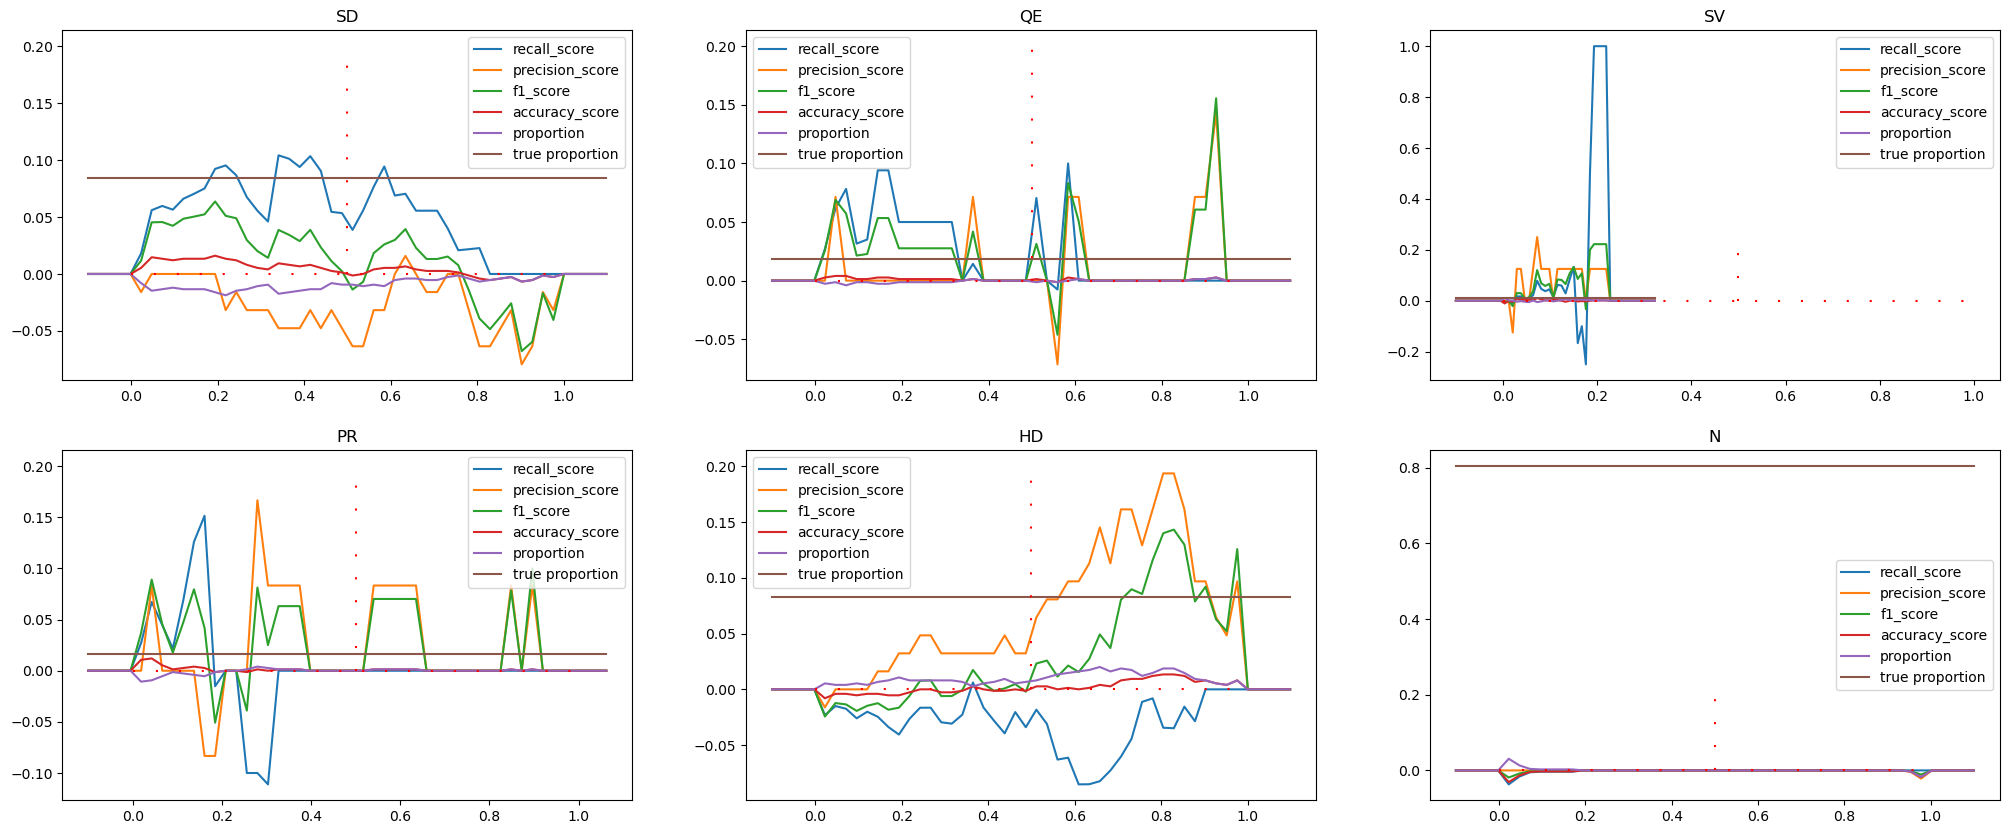

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true[:,i], multimodal_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))


array([[<AxesSubplot: title={'center': 'SD'}>,
        <AxesSubplot: title={'center': 'QE'}>],
       [<AxesSubplot: title={'center': 'SV'}>,
        <AxesSubplot: title={'center': 'PR'}>],
       [<AxesSubplot: title={'center': 'HD'}>,
        <AxesSubplot: title={'center': 'N'}>]], dtype=object)

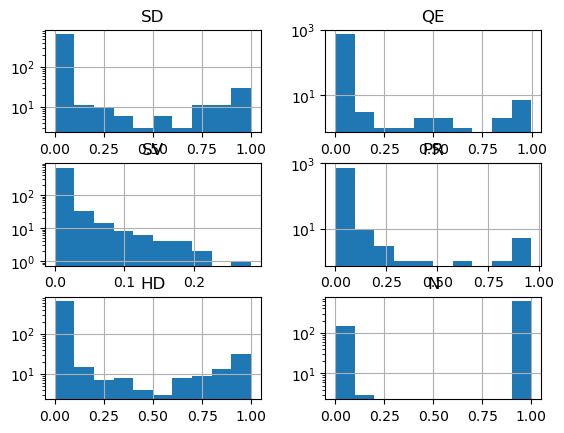

In [57]:
import pandas as pd
df = pd.DataFrame(video_pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df2 = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df.hist(log = True)

array([[<AxesSubplot: title={'center': 'SD'}>,
        <AxesSubplot: title={'center': 'QE'}>],
       [<AxesSubplot: title={'center': 'SV'}>,
        <AxesSubplot: title={'center': 'PR'}>],
       [<AxesSubplot: title={'center': 'HD'}>,
        <AxesSubplot: title={'center': 'N'}>]], dtype=object)

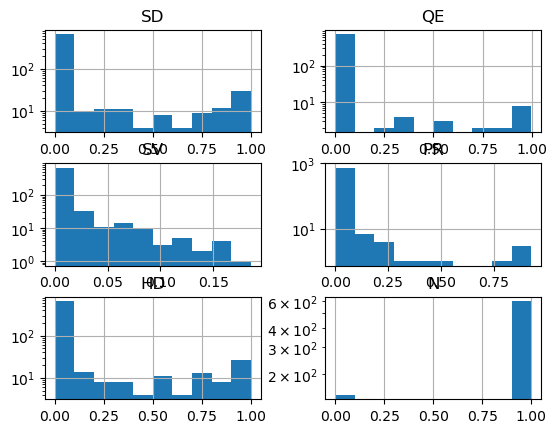

In [39]:
import pandas as pd
df = pd.DataFrame(txt_pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df2 = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df.hist(log = True)

In [42]:
print(txt_pred_n)

[[1.34378476e-02 6.99726996e-08 1.90664832e-05 2.99065093e-08
  1.16295587e-05 9.98262584e-01]
 [1.16765586e-04 1.35837229e-06 1.90297345e-04 8.47058345e-06
  9.27769815e-06 9.99734819e-01]
 [2.13384077e-01 3.19010869e-05 5.32885268e-03 1.16821939e-04
  9.09229696e-01 1.05494924e-03]
 ...
 [8.23691666e-01 3.92610673e-05 1.94551330e-02 1.12695072e-03
  6.99042976e-01 5.92877215e-04]
 [4.40035592e-07 8.22353817e-04 4.87796235e-04 5.71423989e-05
  3.27578273e-05 9.99615908e-01]
 [1.14533805e-06 1.23532209e-05 2.62659451e-04 1.59944011e-05
  3.14134741e-05 9.99884486e-01]]


/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/en

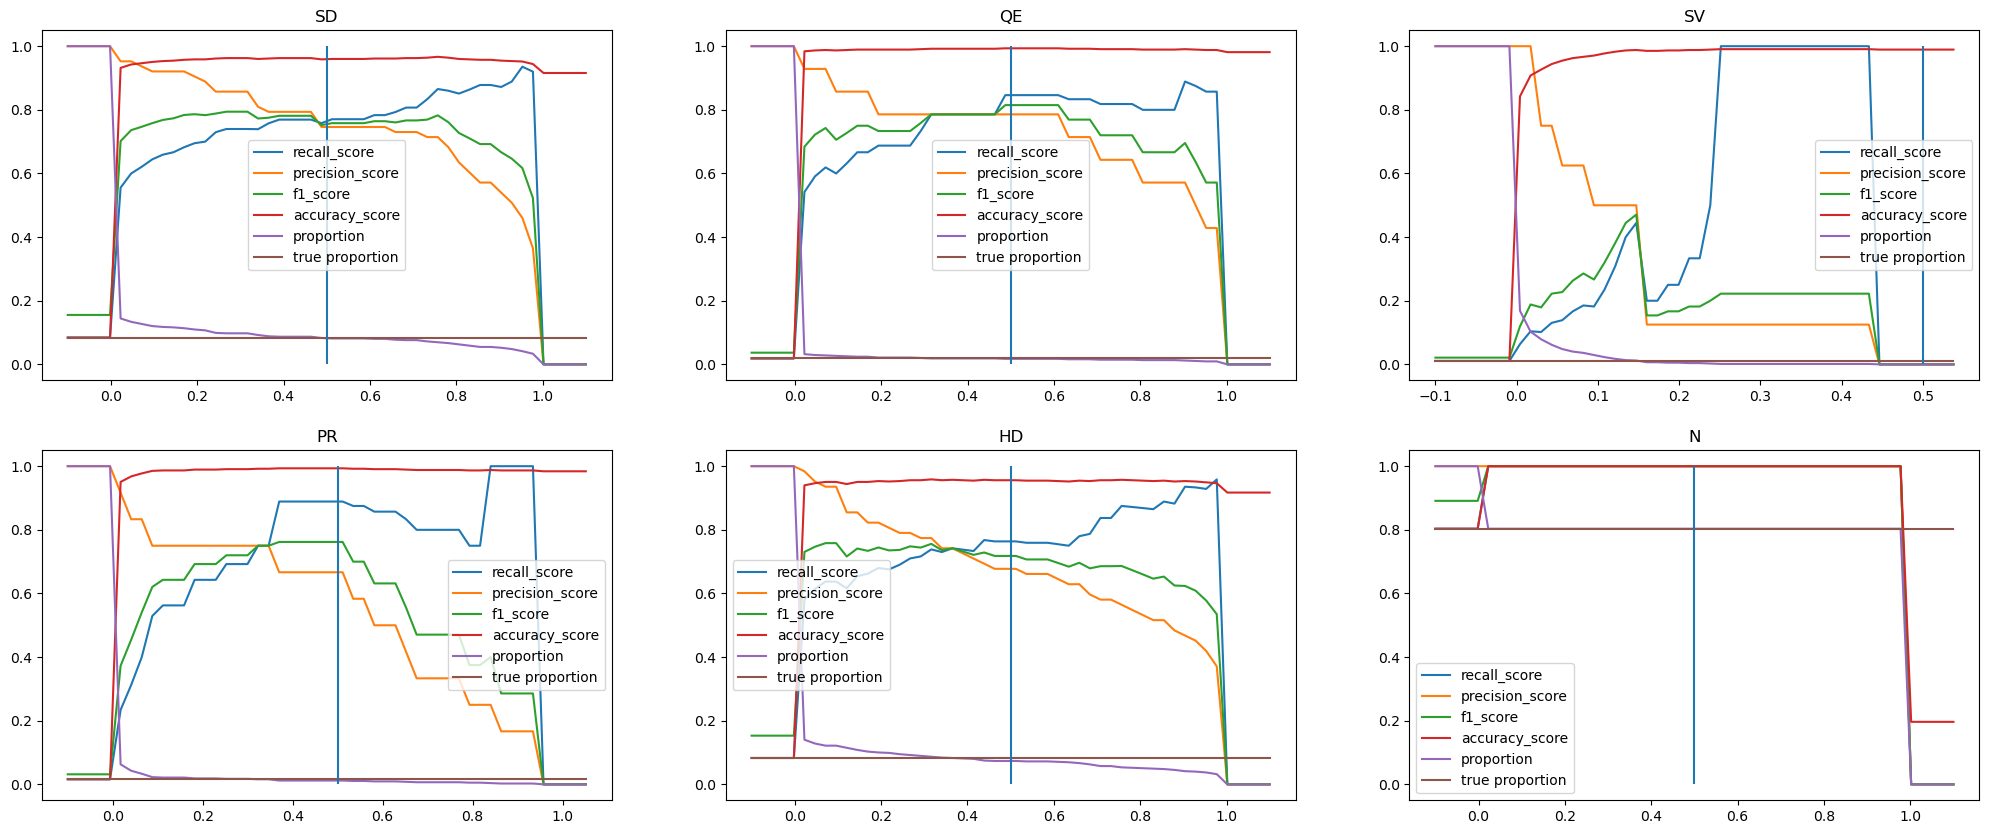

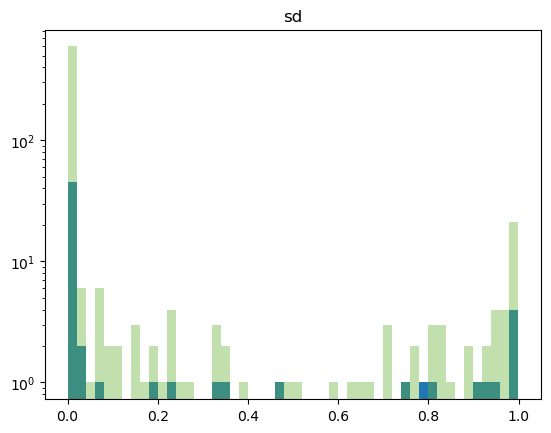

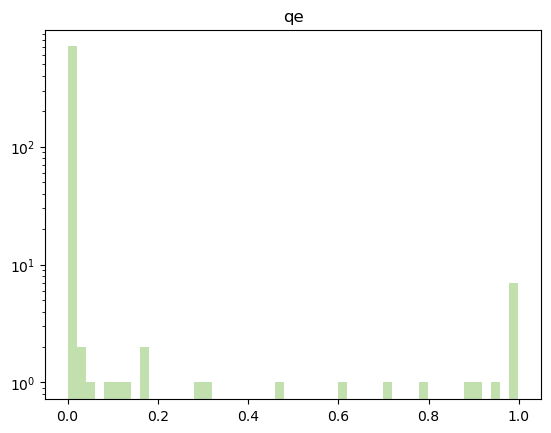

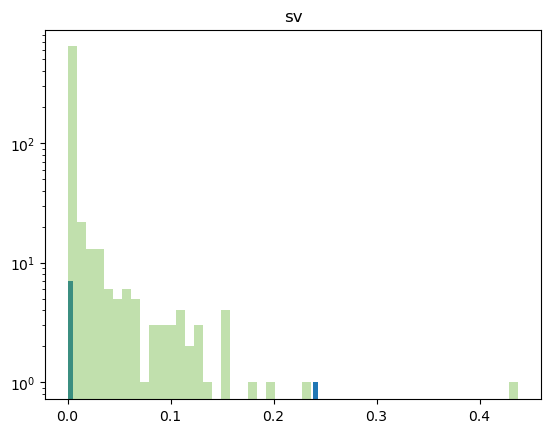

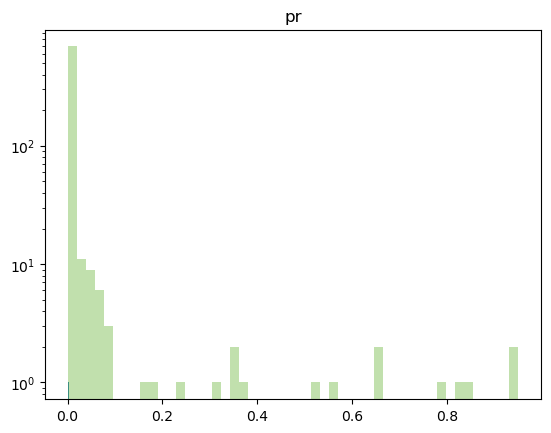

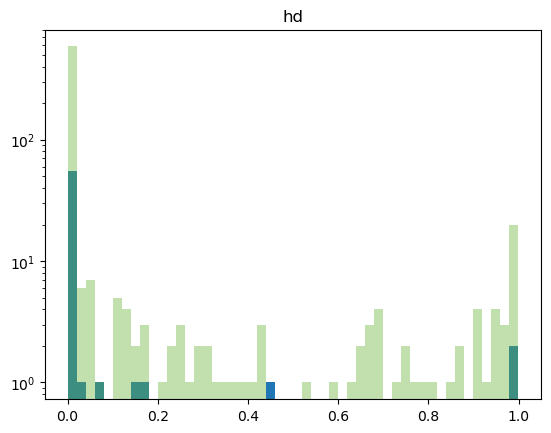

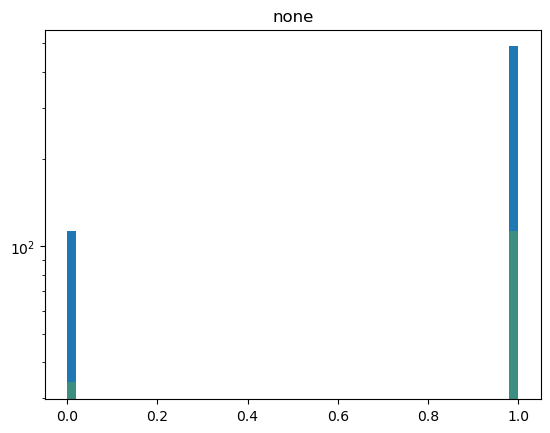

In [ ]:
def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out_txt = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out_txt = pd.DataFrame(out_txt, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out_txt

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
df_pred = pd.DataFrame(video_pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true[:,i], video_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1)
plt.savefig('BEAUTY_text.jpg')
plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("qe")
plt.yscale("log")
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sv")
plt.yscale("log")
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("pr")
plt.yscale("log")
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("hd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("none")
plt.yscale("log")
plt.show()